In this notebook, I will compare several binary classification models using a simulated dataset.

The data is simulated using scikit-learn's ```make_classification```. First, the models will be trained and tested on a simple dataset with 2 relevant features. Later, they will be trained and tested on a more complex dataset with both redundant and repeated features without any feature engineering. ```make_classification``` documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

I will try the following scikit-learn classifiers (click on the model name for documentation): [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html),
[LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html),
[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html),
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

I will also add multiplayer perceptrons in Keras and PyTorch and evaluate their performances.

In [1]:
# create simulated data with 2 features
from sklearn.datasets import make_classification

X, Y = make_classification(n_samples = 1000,
                           n_features = 2,
                           n_informative = 2,
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           random_state = 47)

In [2]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 47)

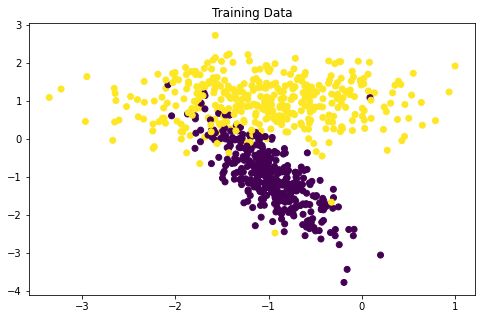

In [3]:
# plot the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

In [4]:
# import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [5]:
# fit logistic regression with default parameters
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
# obtain prediction accuracy on test data 
log_reg.score(X_test, Y_test)

0.928

In [6]:
# fit the decision tree classifier with default parameters
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, Y_train)
# obtain prediction accuracy on test data
dt_clf.score(X_test, Y_test)

0.944

In [7]:
# fit linear SVC with default parameters
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
# obtain prediction accuracy on test data
linear_svc.score(X_test, Y_test)

0.928

In [8]:
# fit K-neighbors classifier with default parameters
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, Y_train)
# obtain prediction accuracy on the test data
kn_clf.score(X_test, Y_test)

0.952

In [9]:
# fit the random forrest classifier with default parameters
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, Y_train)
# obtain prediction accuracy on the test data
rf_clf.score(X_test, Y_test)

0.948

In [10]:
# fit the gradient boosting classifier with default parameters
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, Y_train)
# obtain prediction accuracy on the test data
gb_clf.score(X_test, Y_test)

0.952

In [11]:
%%time
# create a binary classification model in Keras
from keras.models import Sequential
from keras.layers import Dense

# three layer model with 2 feature input and sigmoid output
model = Sequential([
    Dense(30, input_shape=(2,), activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
# compile the model using binary crossentropy as the loss function and
# binary accuracy as the evaluation metric
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
model.fit(X_train, Y_train, epochs = 50)
# evaluate using the test data
model.evaluate(X_test, Y_test)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.6686 - binary_accuracy: 0.6240
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.4943 - binary_accuracy: 0.9200
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3816 - binary_accuracy: 0.9240
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3049 - binary_accuracy: 0.9213
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2563 - binary_accuracy: 0.9253
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.2318 - binary_accuracy: 0.9253
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2183 - binary_accuracy: 0.9267
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2124 - binary_accuracy: 0.9267
Epoch 9/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2080 - binary_accuracy: 0.9293
Epoch 10/50
24/24 [==============================] - 0s

[0.1512237936258316, 0.9440000057220459]

In [12]:
# create a binary classification model in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class TorchBinaryClassifier(nn.Module):
    def __init__(self):
        super(TorchBinaryClassifier, self).__init__()
        # 3 layer NN similar to the one done in Keras
        self.fc1 = nn.Linear(2, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        # sigmoid layer for classification
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        # apply ReLU after each of the first two layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # apply sigmoid function before returning the value
        x = self.sig(x)
        
        return x
    
net = TorchBinaryClassifier()

In [13]:
# specify loss and optimizer
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [14]:
# speficy train and test data
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float().squeeze()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

trainset = TensorDataset(X_train_tensor, Y_train_tensor)
testset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(trainset)
test_loader = DataLoader(testset)

In [15]:
%%time
# train the model
net.train()

for epoch in range(50):
    # zero the running loss for the epch
    running_loss = 0.0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target.view(-1,1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch: {epoch + 1}, training loss: {running_loss/len(train_loader.dataset)}')

Epoch: 1, training loss: 0.2992277131562732
Epoch: 2, training loss: 0.20315119510720495
Epoch: 3, training loss: 0.1960727020473229
Epoch: 4, training loss: 0.19165940095149805
Epoch: 5, training loss: 0.1884831297225707
Epoch: 6, training loss: 0.18564617146220067
Epoch: 7, training loss: 0.182913737780919
Epoch: 8, training loss: 0.1800470654949216
Epoch: 9, training loss: 0.1773063897916048
Epoch: 10, training loss: 0.1749332383234432
Epoch: 11, training loss: 0.17251320260905897
Epoch: 12, training loss: 0.17029453696434818
Epoch: 13, training loss: 0.16809177015419483
Epoch: 14, training loss: 0.1663596855717145
Epoch: 15, training loss: 0.16455800637606202
Epoch: 16, training loss: 0.16308509136774046
Epoch: 17, training loss: 0.16185523634953794
Epoch: 18, training loss: 0.16061180343803547
Epoch: 19, training loss: 0.1590348005255564
Epoch: 20, training loss: 0.15778660252440477
Epoch: 21, training loss: 0.1565957036282022
Epoch: 22, training loss: 0.1577466735529988
Epoch: 23

In [16]:
# evaluate the model
import numpy as np

net.eval()

test_loss = 0.0
correct_predictions = 0

for data, target in test_loader:
    output = net(data)
    loss = criterion(output, target.view(-1,1))
    test_loss += loss.item()
    predicted = np.round(output.detach().numpy().squeeze())
    actual = target.numpy().squeeze()
    if predicted == actual:
        correct_predictions += 1
    
print(f'Accuracy: {correct_predictions/len(test_loader.dataset)}')

Accuracy: 0.952


All models achieved above 90% accuracy. The PyTorch MLP required by far the most lines of code and was the slowest.

Now I will test the same models on a dataset with 4 features, 3 of which are informative, and one is a random linear combination of the others.

In [17]:
X_2, Y_2 = make_classification(n_samples = 1000,
                           n_features = 4,
                           n_informative = 3,
                           n_redundant = 1,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, 
                                                            test_size = 0.25,
                                                            random_state = 47)

<IPython.core.display.Javascript object>


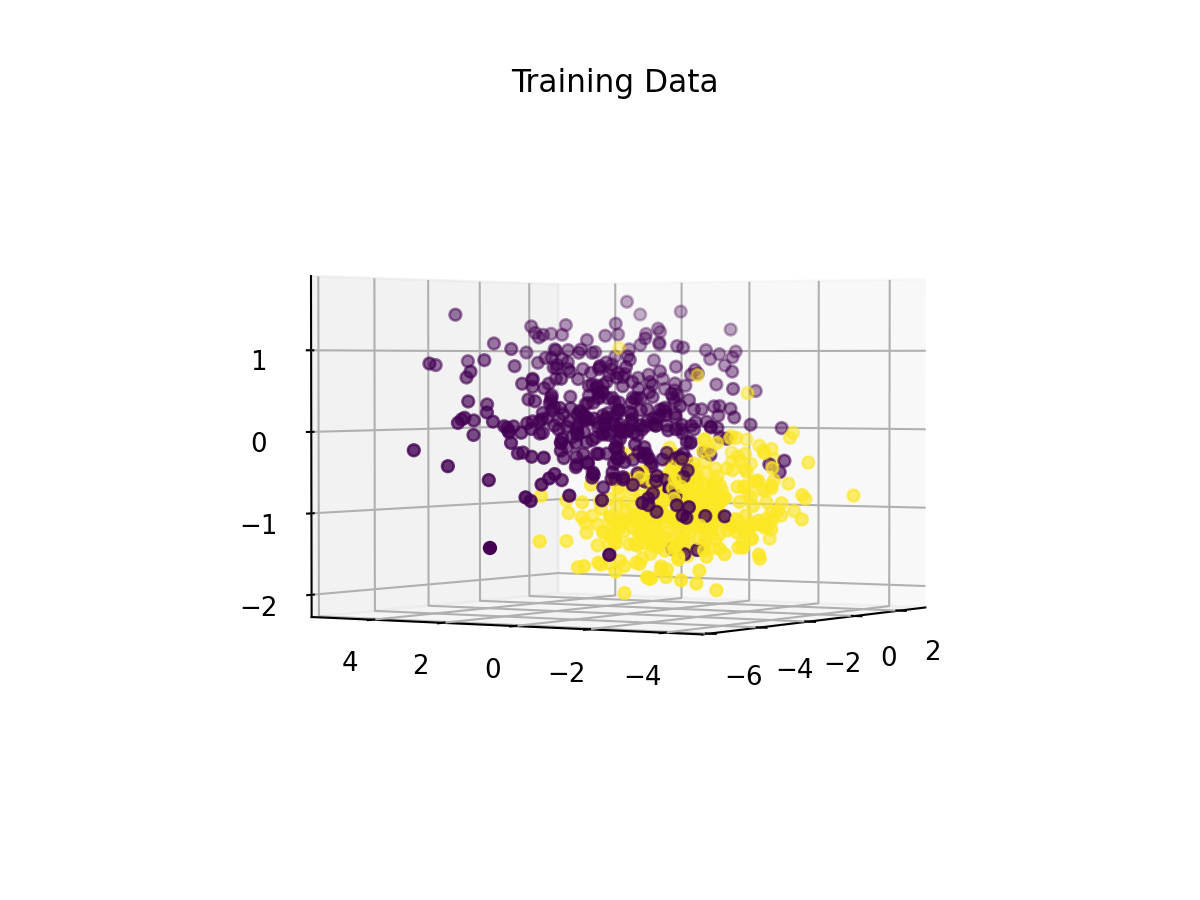

In [18]:
# display the new classes in terms of the first 3 features using an interactive 3d plot
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_2_train[:,0], X_2_train[:,1], X_2_train[:,2], c = Y_2_train)
plt.title('Training Data')
plt.show()

In [19]:
# fit and evaluate logistic regression
log_reg.fit(X_2_train, Y_2_train)
log_reg.score(X_2_test, Y_2_test)

0.928

In [20]:
# fit and evaluate the decision tree classifier
dt_clf.fit(X_2_train, Y_2_train)
dt_clf.score(X_2_test, Y_2_test)

0.916

In [21]:
# fit and evaluate linear SVC
linear_svc.fit(X_2_train, Y_2_train)
linear_svc.score(X_2_test, Y_2_test)

0.928

In [22]:
# fit and evaluate K-neighbors classifier
kn_clf.fit(X_2_train, Y_2_train)
kn_clf.score(X_2_test, Y_2_test)

0.944

In [23]:
# fit and evaluate the random forrest classifier
rf_clf.fit(X_2_train, Y_2_train)
rf_clf.score(X_2_test, Y_2_test)

0.94

In [24]:
# fit and evaluate the gradient boosting classifier
gb_clf.fit(X_2_train, Y_2_train)
gb_clf.score(X_2_test, Y_2_test)

0.948